# Condensation Tutorial: Particle Resolved

*Work in progress, probably split into multiple notebooks, need to find a model system to test this on*

A particle resolved model is a model that tracks the properties of individual particles or collection of particles (e.g., super droplets). This is in contrast to a bulk model, which tracks the properties of the entire aerosol population. The particle resolved model can be more computationally expensive, but can provide more detailed information about the aerosol population.

To run this type of model we will need to use a speciated distribution representation. This is so that we can track the properties of individual particles.


In [55]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next.particles.representation_builders import (
    ParticleMassRepresentationBuilder,
)
from particula.next.particles.distribution_builders import SpeciatedMassMovingBinBuilder
from particula.next.gas.atmosphere_builder import AtmosphereBuilder
from particula.next.gas.vapor_pressure_factories import VaporPressureFactory
from particula.next.gas.species_builders import GasSpeciesBuilder
from particula.next.aerosol import Aerosol
from particula.next.dynamics.particle_process import MassCondensation
from particula.next.dynamics.condensation import CondensationIsothermal
from particula.next.particles.activity_builders import ActivityKappaParameterBuilder
from particula.next.particles.surface_builders import SurfaceStrategyVolumeBuilder
from particula.next.particles.properties.lognormal_size_distribution import lognormal_sample_distribution

## Aerosol Object

First we'll draw from a lognormal distribution to create a set of particles. We'll will then build an aerosol object to represent the aerosol population.


In [56]:
# Ammonium sulfate and water vapor pressure
molar_mass_ammonium_sulfate = 132.14e-3  # kg/mol
molar_mass_water = 18.015e-3  # kg/mol
parameters_vapor = {
    "vapor_pressure": 1e-10,
}
vapor_pressure_ammonium = VaporPressureFactory().get_strategy(
    "constant", parameters_vapor
)
vapor_pressure_water = VaporPressureFactory().get_strategy(
    "water_buck"
)

water_sat = vapor_pressure_water.saturation_concentration(molar_mass=molar_mass_water, temperature=298.15)
water_concentration = 0.8 * water_sat

glycerol_gas = (
    GasSpeciesBuilder()
    .set_molar_mass(np.array([molar_mass_water, molar_mass_ammonium_sulfate]), "kg/mol")
    .set_vapor_pressure_strategy([vapor_pressure_water, vapor_pressure_ammonium])
    .set_concentration(np.array([water_concentration, 0.0]), "kg/m^3")
    .set_name(["H2O", "NH4HSO4"])
    .set_condensable([True, True])
    .build()
)

atmosphere = (
    AtmosphereBuilder()
    .add_species(glycerol_gas)
    .set_temperature(25, temperature_units="degC")
    .set_pressure(1, pressure_units="atm")
    .build()
)




## Sample Distribution

Next we'll sample the distribution to get a set of particles. We'll then build an aerosol object to represent the aerosol population.

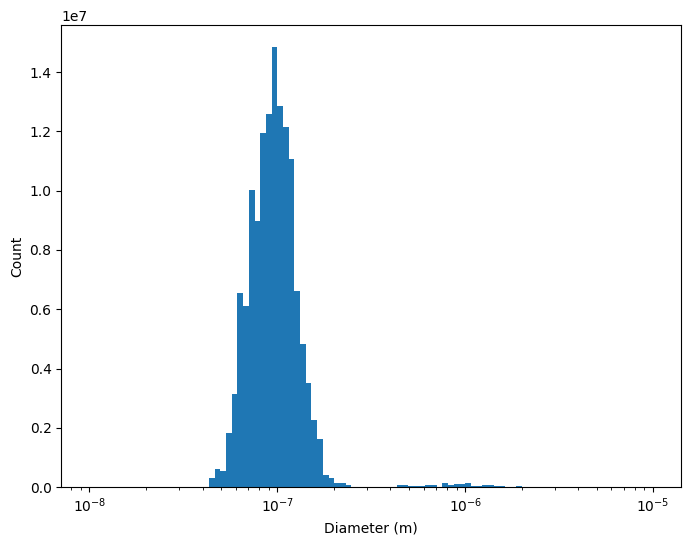

In [57]:
# sample
particles_sample = lognormal_sample_distribution(
    mode=np.array([100, 1000])*1e-9,
    geometric_standard_deviation=np.array([1.3, 1.5]),
    number_of_particles=np.array([1e3, 1e2]),
    number_of_samples=1000,
)

# histogram lognormal
bins_lognormal = np.logspace(-8, -5, 100)
bins, edges = np.histogram(particles_sample, bins=bins_lognormal, density=True)
# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge")
ax.set_xscale("log")
ax.set_xlabel("Diameter (m)")
ax.set_ylabel("Count")
plt.show()

In [58]:
# particle radis to mass
density = 1.26e3  # kg/m^3
particle_mass = density * 4 / 3 * np.pi * particles_sample ** 3
mass_speciation = np.array([particle_mass*0, particle_mass]).T  # water, ammonium sulfate
concentration = np.ones_like(particles_sample) * 1e6
densities = np.array([1000, 1.26e3])  # kg/m^3

print(mass_speciation.shape)

activity_strat = (
    ActivityKappaParameterBuilder()
    .set_density(densities)
    .set_kappa(np.array([0.0, 0.61]))
    .set_molar_mass(np.array([molar_mass_water, molar_mass_ammonium_sulfate]))
    .set_water_index(0)
    .build()
)

surface_strat = (
    SurfaceStrategyVolumeBuilder()
    .set_density(densities)
    .set_surface_tension(np.array([0.072, 0.092]))
    .build()
)

paritcle_rep = (
    ParticleMassRepresentationBuilder()
    .set_distribution_strategy(SpeciatedMassMovingBinBuilder().build())
    .set_surface_strategy(surface_strat)
    .set_activity_strategy(activity_strat)
    .set_density(densities)
    .set_charge(0.0)
    .set_mass(mass_speciation)
    .set_concentration(concentration, "1/cm^3")
    .build()
)

aerosol = Aerosol(atmosphere=atmosphere, particles=paritcle_rep)

print(aerosol.atmosphere)
print(aerosol.particles[0].get_total_mass())

(1000, 2)
Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['H2O', 'NH4HSO4']"]
1.1125033855503565


## Condensation Process

Using the same iso thermal condensation process as in the bulk model, we'll update the properties of the particles in the aerosol object. In this cas we will change the water saturation ratio to be 80% and simulate the condensation process.

Inital rate: [ 3.26274208e-06 -9.02273955e-24  4.04952911e-06 -1.53249046e-23
  2.15929641e-06]...


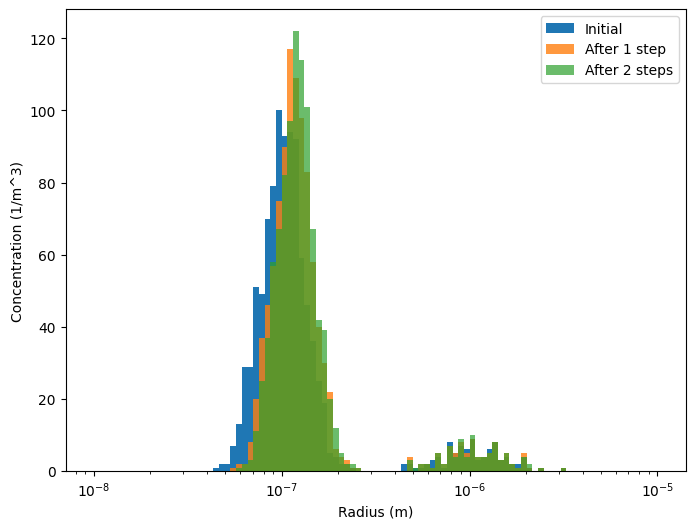

In [59]:
# define the condensation process
condensation_isothermal = CondensationIsothermal(
    molar_mass=np.array([molar_mass_water, molar_mass_ammonium_sulfate]),  # kg/mol
    diffusion_coefficient=2.0*1e-9,
    accommodation_coefficient=0.1,  #makes things go slower/faster
)
condensation_process = MassCondensation(condensation_strategy=condensation_isothermal)

# define the time array in seconds
time_step = 0.5
time_array = np.arange(0, 5, time_step)
total_mass = np.zeros_like(time_array)

# output arrays
aerosol_sim = []

rate = condensation_process.rate(aerosol)
print(f"Inital rate: {rate[:5]}...")

fig, ax = plt.subplots(figsize=(8, 6))
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="Initial")

# one step
aerosol = condensation_process.execute(aerosol, time_step)
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="After 1 step", alpha=0.8)

# 10 seconds
aerosol = condensation_process.execute(aerosol, 1)
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="After 2 steps", alpha=0.7)


ax.set_xscale("log")
# ax.set_yscale("log")
plt.legend()
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Concentration (1/m^3)")
plt.show()

In [60]:
aerosol.atmosphere.species[0].get_concentration()

array([4.33680869e-19, 2.70864446e-17])

## Small Particles Grow Faster

We can see from the previous example that the smaller particles grow faster than the larger particles. This is because the smaller particles have a higher surface area to volume ratio, which means they can take up more water.

However, that

## Summary

We built out the condensation process, and the equations that define the process. We also defined the inputs and outputs of the process. Next we will build out coagulation and nucleation processes, to complete the aerosol dynamics framework.